In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from numba import njit
import numba

caseNum=4
# Jupyter Notebookでグラフをインライン表示するためのマジックコマンド
%matplotlib inline

# グラフのスタイルを少しきれいにします (お好みで)
plt.style.use('ggplot')

print("ライブラリのインポート完了。")

ライブラリのインポート完了。


## --- グローバル設定 ---


In [3]:
# --- グローバル設定 ---

# 保存先フォルダ名
OUTPUT_DIR = 'output'

# モニターコンデンサの容量 [F]
C_m_Farad = 3300E-12    # 3300[pF]

# 波形の周波数 [Hz] 電源の周波数
f_Hz = 9600.0

# ★★★ 追加 ★★★
# デバイスの長さ [m] (W/m の計算用)
# 9.81 cm = 0.0981 m
device_length_meters = 0.0981

#保存先
FILENAME_TEMPLATE = 'testdata/ALL{caseNum:04d}.CSV' 

#Headerは飛ばして数値が始まる場所
skipRowNum = 25

# --- フォルダ作成 ---
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"フォルダ '{OUTPUT_DIR}' を作成しました。")

## --- 解析ロジックの関数定義 ---


### CSVファイルからメタデータと電圧データを読み込む関数


In [4]:
def load_data_and_metadata(filename):
    """
    CSVファイルからメタデータと電圧データを読み込む関数 (修正版)
    """
    print(f"--- ファイル読み込み開始: {filename} ---")
    
    # 1. メタデータの自動抽出
    metadata = {}
    keys_to_extract = ['Memory Length', 'Sampling Period', 'Trigger Address', 'Horizontal Scale']
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            for i, row in enumerate(reader):
                if i >= skipRowNum: break
                if not row: continue
                
                key = row[0]
                if key in keys_to_extract and key not in metadata:
                    metadata[key] = row[1]
        
        # 必要なキーが揃っているかチェック
        for key in keys_to_extract:
            if key not in metadata:
                # 必要なキーが見つからなかった場合、KeyErrorを発生させる
                raise KeyError(f"必要なキー '{key}' がヘッダーに見つかりません。")

        # 2. メタデータの型変換
        meta_typed = {
            'MEMORY_LENGTH': int(metadata['Memory Length']),
            'SAMPLING_PERIOD': float(metadata['Sampling Period']),
            'TRIGGER_ADDRESS': int(metadata['Trigger Address']),
            'HORIZONTAL_SCALE': float(metadata['Horizontal Scale'])
        }
        print("メタデータの抽出成功:")
        for key, val in meta_typed.items():
            print(f"  {key}: {val}")

    except FileNotFoundError:
        print(f"エラー: ファイル {filename} が見つかりません。")
        return None, None, None # ★修正1: 戻り値を3つに
    except Exception as e:
        print(f"メタデータ抽出エラー: {e}")
        return None, None, None # ★修正1: 戻り値を3つに

    # 3. データ本体の読み込み
    df = pd.read_csv(
        filename,
        skiprows=skipRowNum, # ★修正2: 波括弧 {} を削除
        header=None,
        usecols=[1, 3], #時間の値は必要ないので排除
        names=['CH1_VOLTAGE', 'CH2_VOLTAGE']
    )
    ch1_v = df['CH1_VOLTAGE'].to_numpy()
    ch2_v = df['CH2_VOLTAGE'].to_numpy()
    
    print(f"データ読み込み完了 (サンプル数: {len(ch1_v)})")
    return meta_typed, ch1_v, ch2_v

### メタデータから時間軸 (ms) を計算する関数


In [5]:

def calculate_time_axis(metadata):
    Sample_Index = np.arange(metadata['MEMORY_LENGTH'])
    Time = (Sample_Index - metadata['TRIGGER_ADDRESS']) * metadata['SAMPLING_PERIOD']
    Time_ms = Time * 1000
    print(f"時間軸を生成しました: {Time_ms.min():.2f} ms ～ {Time_ms.max():.2f} ms")
    return Time_ms


###  全体波形とズーム波形をプロットし保存する関数


In [6]:
def plot_waveforms(Time_ms, CH1_VOLTAGE, CH2_VOLTAGE, HORIZONTAL_SCALE, caseNum, base_output_dir):

    # --- ケース別サブフォルダのパスを決定し、作成 ---
    case_dir = os.path.join(base_output_dir, f'Case_{caseNum}')
    os.makedirs(case_dir, exist_ok=True) # フォルダが既にあってもエラーにしない

    # --- 4. 【プロット1】全体波形 ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(Time_ms, CH1_VOLTAGE, color='b', label='CH1 Voltage (HV 1000x)', alpha=0.9)
    ax1.set_xlabel('Time [ms]'); ax1.set_ylabel('CH1 Voltage [V]', color='b')
    ax1.tick_params(axis='y', labelcolor='b'); ax1.grid(True, linestyle='--', alpha=0.6)
    ax2 = ax1.twinx()
    ax2.plot(Time_ms, CH2_VOLTAGE, color='r', label='CH2 Voltage (Diff 1x)', alpha=0.9)
    ax2.set_ylabel('CH2 Voltage [V]', color='r'); ax2.tick_params(axis='y', labelcolor='r')
    ax1.axvline(x=0, color='k', linestyle=':', linewidth=2, label='Trigger Point (t=0)')
    fig.suptitle(f'Waveform (Full Range) - Case {caseNum}', fontsize=16)
    lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right'); plt.tight_layout()
    
    # サブフォルダに保存
    save_path_full = os.path.join(case_dir, f"Waveform_Full_Case_{caseNum}.png")
    plt.savefig(save_path_full); plt.show()

    # --- 5. 【プロット2】ズーム波形 ---
    zoom_range_ms = 5 * HORIZONTAL_SCALE * 1000
    fig_zoom, ax_zoom = plt.subplots(figsize=(12, 6))
    ax_zoom.plot(Time_ms, CH1_VOLTAGE, color='b', label='CH1 Voltage (HV 1000x)')
    ax_zoom2 = ax_zoom.twinx()
    ax_zoom2.plot(Time_ms, CH2_VOLTAGE, color='r', label='CH2 Voltage (Diff 1x)')
    ax_zoom.axvline(x=0, color='k', linestyle=':', linewidth=2, label='Trigger Point (t=0)')
    ax_zoom.set_xlim(-zoom_range_ms, zoom_range_ms)
    ax_zoom.set_xlabel('Time [ms]'); ax_zoom.set_ylabel('CH1 Voltage [V]', color='b')
    ax_zoom2.set_ylabel('CH2 Voltage [V]', color='r'); ax_zoom.tick_params(axis='y', labelcolor='b')
    ax_zoom2.tick_params(axis='y', labelcolor='r'); fig_zoom.suptitle(f'Waveform Zoom (±{zoom_range_ms:.2f} ms) - Case {caseNum}', fontsize=16)
    lines, labels = ax_zoom.get_legend_handles_labels(); lines2, labels2 = ax_zoom2.get_legend_handles_labels()
    ax_zoom.legend(lines + lines2, labels + labels2, loc='upper right'); ax_zoom.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    
    # サブフォルダに保存
    save_path_zoom = os.path.join(case_dir, f"Waveform_Zoom_Case_{caseNum}.png")
    plt.savefig(save_path_zoom); plt.show()
    print(f"波形プロットを {case_dir} に保存しました。")

###  DCオフセットを除去する関数


In [7]:

def calculate_ac_components(CH1_VOLTAGE, CH2_VOLTAGE):
    CH1_AC = CH1_VOLTAGE - np.mean(CH1_VOLTAGE)
    CH2_AC = CH2_VOLTAGE - np.mean(CH2_VOLTAGE)
    print("DCオフセットを除去しました。")
    return CH1_AC, CH2_AC


###     リサージュグラフを描画・保存する関数


In [8]:
def plot_and_save_lissajous(CH1_AC, CH2_AC, caseNum, base_output_dir):
    # --- ケース別サブフォルダのパスを決定し、作成 ---
    case_dir = os.path.join(base_output_dir, f'Case_{caseNum}')
    os.makedirs(case_dir, exist_ok=True) # フォルダが既にあってもエラーにしない
    
    fig_qv, ax_qv = plt.subplots(figsize=(8, 7))
    ax_qv.plot(CH1_AC, CH2_AC, color='navy', linewidth=0.5)
    title_str = f'Lissajous Figure (Q-V Curve) - Case {caseNum}'
    ax_qv.set_title(title_str, fontsize=16)
    ax_qv.set_xlabel('CH1 Voltage (V) [Offset Removed]'); ax_qv.set_ylabel('CH2 Voltage (Q) [Offset Removed]')
    ax_qv.grid(True, linestyle=':', alpha=0.7); ax_qv.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax_qv.axvline(0, color='k', linestyle='--', linewidth=0.5); plt.tight_layout()
    
    # サブフォルダに保存
    save_path = os.path.join(case_dir, f"Lissajous_Case_{caseNum}.png")
    plt.savefig(save_path, dpi=150)
    print(f"リサージュグラフを {save_path} に保存しました。")
    plt.show()

### リサージュ面積と消費電力を計算する関数


In [9]:
@njit(fastmath=True, cache=True)
def calculate_shoelace_area_numba(x, y):
    n = len(x)
    area = 0.0 
    
    # Numba が高速化する for ループ
    for i in range(n):
        j = (i + 1) % n 
        area += (x[i] * y[j])
        area -= (x[j] * y[i])
        
    return 0.5 * np.abs(area)

def calculate_power(CH1_AC, CH2_AC, C_m_Farad, metadata, caseNum):
    """
    リサージュ面積から「平均消費電力」を正しく計算する関数
    (Numba を使用して全データ(100万点)を高速に計算)
    """
    
    print(f"Numba (JITコンパイル) を使用して {len(CH1_AC)} 点のフルデータで面積計算を実行します...")
    
    # 1. 面積計算 (Numba 関数を呼び出す)
    # ★ 100万点のフルデータを渡す
    # ★ 古い np.sum(...) の計算は完全に削除する
    Area_VV = calculate_shoelace_area_numba(CH1_AC, CH2_AC)

    # 2. 全エネルギー [J] の計算
    Energy_Total_J = Area_VV * C_m_Farad

    # 3. 全計測時間 [s] の計算
    Total_Time_s = metadata['MEMORY_LENGTH'] * metadata['SAMPLING_PERIOD']
    
    # 4. 平均消費電力 [W] の計算
    Power_Watt = Energy_Total_J / Total_Time_s

    # (print文は変更なし)
    print(f"\n--- [Case {caseNum}] 消費電力の計算結果 (修正版) ---")
    print(f"リサージュ図形の総面積 (Area_VV): {Area_VV:.2f} [V*V]")
    print(f"総エネルギー (E_total): {Energy_Total_J:.2e} [J]")
    print(f"総計測時間 (t_total): {Total_Time_s:.4f} [s]")
    print(f"----------------------------------------")
    print(f"平均消費電力 (P): {Power_Watt:.4f} [W]")
    
    return Power_Watt, Area_VV

### [未使用] 単一ケースの全解析を実行するラッパー関数(ウィジェットから呼び出される)

In [10]:
def run_single_case_analysis(caseNum, base_output_dir, C_m_Farad):
    print(f"=====================================")
    print(f"         STARTING ANALYSIS FOR CASE {caseNum}         ")
    print(f"=====================================")
    
    filename = FILENAME_TEMPLATE.format(caseNum=caseNum)
    metadata, CH1_V, CH2_V = load_data_and_metadata(filename) # metadata を取得

    if metadata:
        Time_ms = calculate_time_axis(metadata)
        plot_waveforms(Time_ms, CH1_V, CH2_V, metadata['HORIZONTAL_SCALE'], caseNum, base_output_dir)
        CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
        plot_and_save_lissajous(CH1_AC, CH2_AC, caseNum, base_output_dir)
        
        # ★★★ 呼び出し方を修正 (f_Hz を metadata に) ★★★
        Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, metadata, caseNum)
        
        print(f"=====================================")
        print(f"         ANALYSIS FOR CASE {caseNum} COMPLETE        ")
        print(f"=====================================")
    else:
        print(f"Case {caseNum} の処理をスキップしました (ファイルエラー)。")

In [11]:
def plot_sampling_period_comparison(results_list, output_dir):
    """
    (Cell 6 の後半)
    サンプリング周期 vs 消費電力のグラフを描画・保存する関数
    """
    
    # (★ scipy.interpolate と numpy のインポートは Cell 1 にある前提)
    from scipy.interpolate import make_interp_spline
    import numpy as np

    if not results_list:
        print("データがないため、プロットをスキップしました。")
        return

    # --- 比較結果のサマリー (4点プロット + CSV保存) ---
    results_df = pd.DataFrame(results_list).set_index('Case')
    results_df_sorted = results_df.sort_index()
    
    print("--- 解析結果サマリー (Case 1-4) ---")
    print(results_df_sorted)
    
    csv_save_path = os.path.join(output_dir, "Comparison_SamplingPeriod_vs_Power_All_4_Cases.csv")
    results_df_sorted.to_csv(csv_save_path)
    print(f"\nサマリーデータを {csv_save_path} に保存しました。")
    
    fig_sp, ax_sp = plt.subplots(figsize=(10, 7))
    
    x_data = results_df_sorted['Sampling Period (s)']
    y_data = results_df_sorted['Power (W)']
    
    ax_sp.plot(
        x_data,
        y_data,
        'o-', # 3番目の引数としてスタイルを指定
        markersize=8,
        label='Measured Power'
    )

    y_min, y_max = ax_sp.get_ylim()
    vertical_offset = (y_data.max() - y_data.min()) * 0.1 

    for case_num, row in results_df_sorted.iterrows():
        x_val = row['Sampling Period (s)']
        y_val = row['Power (W)']
        
        ax_sp.text(
            x_val, 
            y_val - vertical_offset,
            f"Case {case_num}",
            ha='center',
            va='top',
            color='blue',
            fontsize=9
        )

    ax_sp.set_title('Sampling Period vs. Power Consumption (Case 1-4)')
    ax_sp.set_xlabel('Sampling Period [s]')
    ax_sp.set_ylabel('Total Power Consumption [W]')
    ax_sp.legend()
    ax_sp.grid(True, linestyle=':', alpha=0.7)
    ax_sp.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    new_y_min = y_data.min() - vertical_offset * 1.5
    ax_sp.set_ylim(bottom=new_y_min)
    
    plt.tight_layout()
    comp_save_path = os.path.join(output_dir, "Comparison_SamplingPeriod_vs_Power.png")
    plt.savefig(comp_save_path, dpi=150)
    print(f"比較サマリーグラフを {comp_save_path} に保存しました。")
    plt.show()

print("関数 'run_sampling_period_analysis' と 'plot_sampling_period_comparison' を定義しました。")

関数 'run_sampling_period_analysis' と 'plot_sampling_period_comparison' を定義しました。


# --- メイン実行 (単一ケース) ---


--- ファイル読み込み開始: testdata/ALL0004.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 1e-08
  TRIGGER_ADDRESS: 500999
  HORIZONTAL_SCALE: 0.001
データ読み込み完了 (サンプル数: 1000000)
時間軸を生成しました: -5.01 ms ～ 4.99 ms


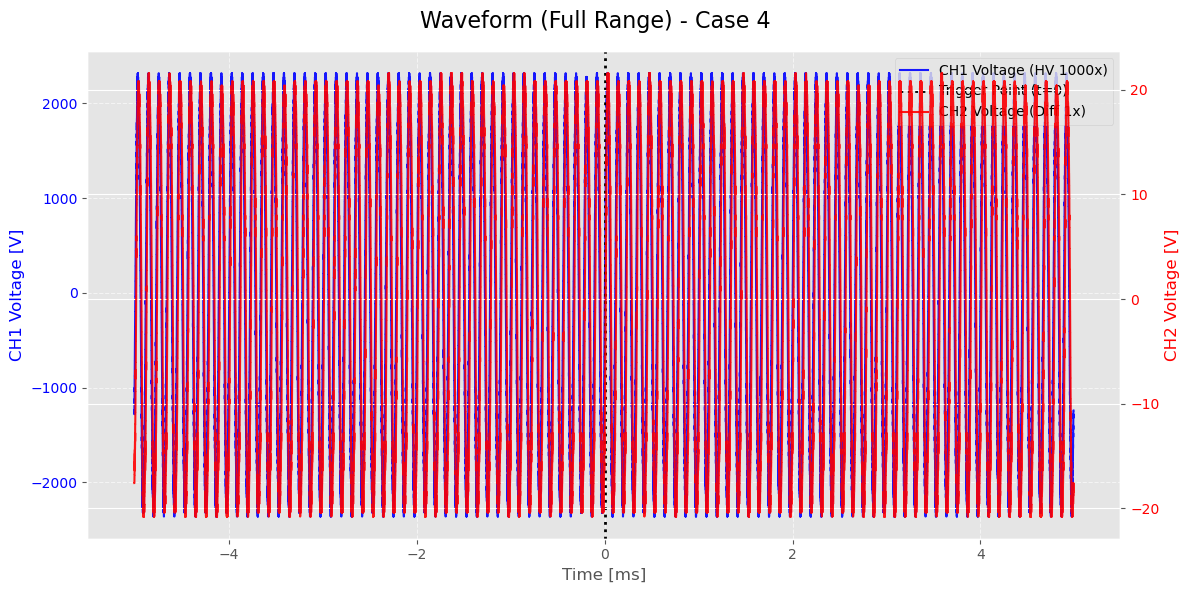

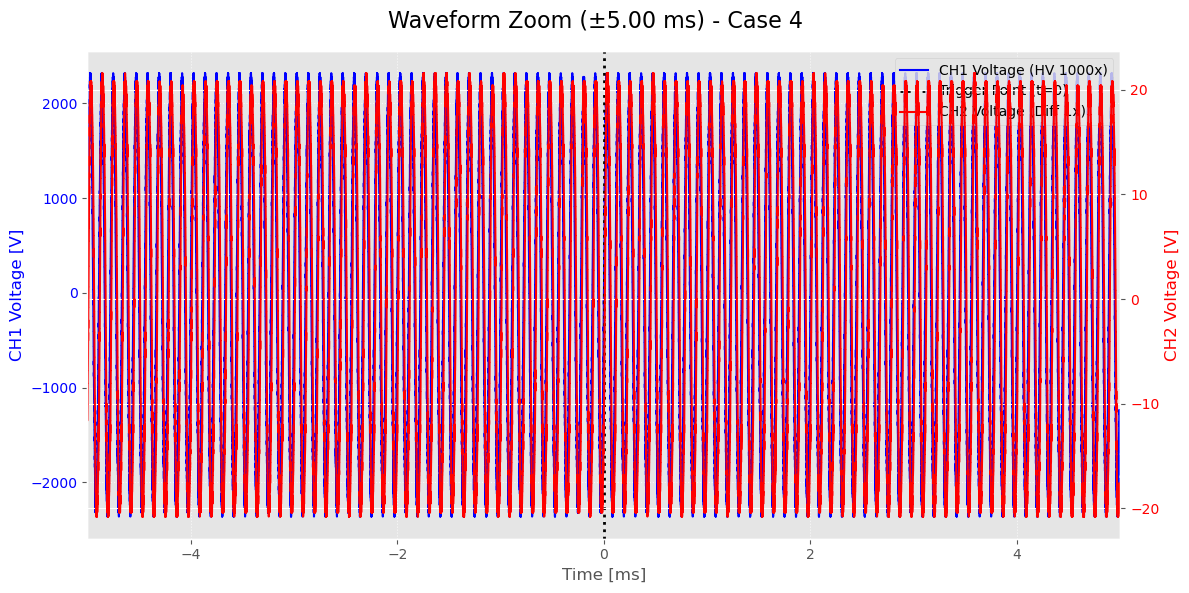

波形プロットを output/Case_4 に保存しました。
DCオフセットを除去しました。
リサージュグラフを output/Case_4/Lissajous_Case_4.png に保存しました。


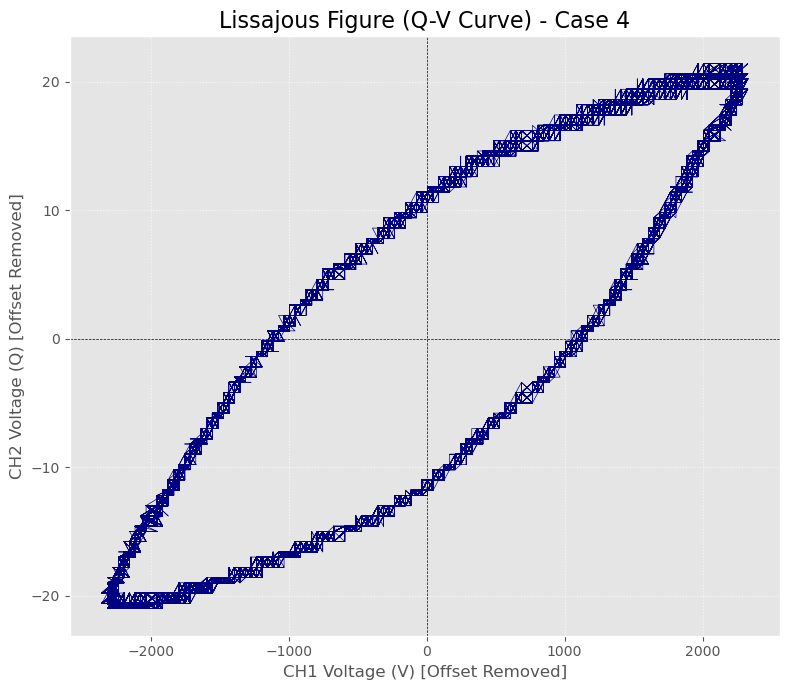

Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します...

--- [Case 4] 消費電力の計算結果 (修正版) ---
リサージュ図形の総面積 (Area_VV): 6241168.00 [V*V]
総エネルギー (E_total): 2.06e-02 [J]
総計測時間 (t_total): 0.0100 [s]
----------------------------------------
平均消費電力 (P): 2.0596 [W]


In [15]:
filename = FILENAME_TEMPLATE.format(caseNum=caseNum)
metadata, CH1_V, CH2_V = load_data_and_metadata(filename) 

if metadata:
    # 2. 時間軸の計算
    Time_ms = calculate_time_axis(metadata)
    
    # 3. 波形プロット
    plot_waveforms(Time_ms, CH1_V, CH2_V, metadata['HORIZONTAL_SCALE'], caseNum, OUTPUT_DIR)
    
    # 4. DCオフセット除去
    CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
    
    # 5. リサージュグラフの描画と保存
    plot_and_save_lissajous(CH1_AC, CH2_AC, caseNum, OUTPUT_DIR)
    
    # 6. 消費電力の計算
    # ★★★ 呼び出し方を修正 (f_Hz を metadata に) ★★★
    Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, metadata, caseNum)

else:
    print(f"Case {caseNum} の処理をスキップしました (ファイルエラー)。")

# --- case5-10の消費電力比較 ---


--- 全ケースのバッチ処理を開始します ---

            PROCESSING CASE 5         
--- ファイル読み込み開始: testdata/ALL0005.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0002
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 1040.00 V
リサージュグラフを output/Case_5/Lissajous_Case_5.png に保存しました。
Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します...

--- [Case 5] 消費電力の計算結果 (修正版) ---
リサージュ図形の総面積 (Area_VV): 29000.00 [V*V]
総エネルギー (E_total): 9.57e-05 [J]
総計測時間 (t_total): 0.0020 [s]
----------------------------------------
平均消費電力 (P): 0.0478 [W]
電力密度 (P/m): 0.488 [W/m] (長さ: 0.0981 m)

            PROCESSING CASE 6         
--- ファイル読み込み開始: testdata/ALL0006.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0002
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 2120.00 V
リサージュグラフを output/Case_6/Lissajous_Case_6.png に保存しました。
Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します.

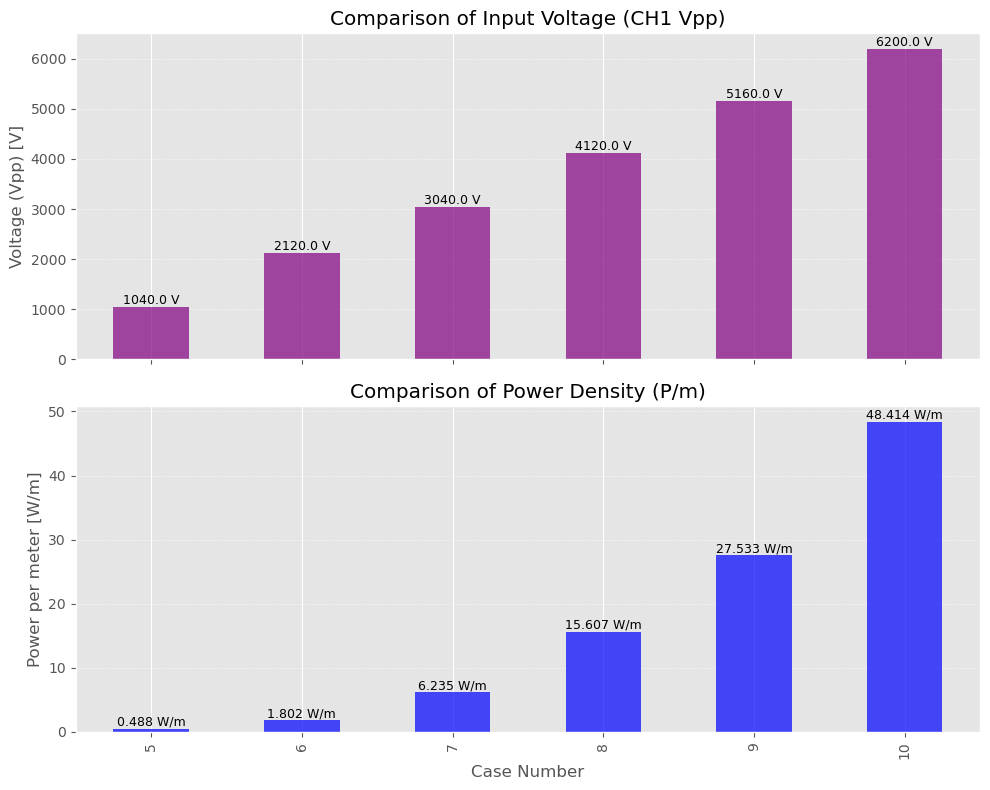

In [ ]:
# --- (将来用) 全ケースのループ実行と比較 (Vpp と Power/meter のみ) ---

print("--- 全ケースのバッチ処理を開始します ---")

# 解析結果を格納するリスト
all_results = []
# ★ ユーザー指定のケース番号
case_numbers_to_run = [5, 6, 7, 8, 9, 10] 
# case_numbers_to_run = [1,2,3,4] # ★ OK!・


for num in case_numbers_to_run:
    
    print(f"\n=====================================")
    print(f"            PROCESSING CASE {num}         ")
    print(f"=====================================")
    
    filename = FILENAME_TEMPLATE.format(caseNum=num)
    metadata, CH1_V, CH2_V = load_data_and_metadata(filename) # metadata を取得
    
    if metadata:
        # DCオフセット除去
        CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
        
        # --- 印加電圧 (Vpp) の計算 ---
        v_pp = CH1_AC.max() - CH1_AC.min()
        print(f"CH1 Vpp (印加電圧): {v_pp:.2f} V")
        
        # --- リサージュ保存 (サブフォルダに保存) ---
        # (省略) ...
        case_dir = os.path.join(OUTPUT_DIR, f'Case_{num}') 
        os.makedirs(case_dir, exist_ok=True) 
        fig_qv, ax_qv = plt.subplots(figsize=(8, 7))
        ax_qv.plot(CH1_AC, CH2_AC, color='navy', linewidth=0.5)
        ax_qv.set_title(f'Lissajous Figure (Q-V Curve) - Case {num}')
        ax_qv.set_xlabel('CH1 (V)'); ax_qv.set_ylabel('CH2 (Q)')
        ax_qv.grid(True); ax_qv.axhline(0, color='k', lw=0.5); ax_qv.axvline(0, color='k', lw=0.5)
        plt.tight_layout()
        save_path = os.path.join(case_dir, f"Lissajous_Case_{num}.png") 
        plt.savefig(save_path, dpi=150)
        plt.close(fig_qv) 
        print(f"リサージュグラフを {save_path} に保存しました。")

        Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, metadata, num)
        
        # --- W/m の計算 ---
        Power_per_meter = Power / device_length_meters
        print(f"電力密度 (P/m): {Power_per_meter:.3f} [W/m] (長さ: {device_length_meters} m)")
        
        # 結果を保存
        all_results.append({
            'Case': num,
            'Power (W)': Power,
            'Power_per_meter (W/m)': Power_per_meter, # ★ W/m も追加
            'Area (V*V)': Area, # (注: この面積は「総面積」です)
            'Vpp (V)': v_pp,
            'Sampling Period (s)': metadata['SAMPLING_PERIOD'],
            'Horizontal Scale (s/div)': metadata['HORIZONTAL_SCALE']
        })
    else:
        print(f"Case {num} はスキップされました。")

print("\n=====================================")
print("       全ケースの処理が完了しました       ")
print("=====================================")

# --- 比較結果のサマリー ---
if all_results:
    # Pandas DataFrame にして結果を見やすく表示
    results_df = pd.DataFrame(all_results).set_index('Case')
    print(results_df)
    
    # --- ★★★ 比較グラフの作成 (2段、W/m に変更) ★★★ ---
    fig_comp, (ax_v, ax_pm) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # --- 1. 印加電圧 (Vpp) の比較 ---
    # (省略) ...
    results_df['Vpp (V)'].plot(kind='bar', ax=ax_v, color='purple', alpha=0.7)
    ax_v.set_title('Comparison of Input Voltage (CH1 Vpp)')
    ax_v.set_ylabel('Voltage (Vpp) [V]')
    ax_v.grid(axis='y', linestyle=':', alpha=0.7)
    for patch in ax_v.patches:
        ax_v.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), 
                  f'{patch.get_height():.1f} V', ha='center', va='bottom', fontsize=9)

    # --- 2. メートルあたり消費電力 (W/m) の比較 ---
    # (省略) ...
    results_df['Power_per_meter (W/m)'].plot(kind='bar', ax=ax_pm, color='blue', alpha=0.7)
    ax_pm.set_title('Comparison of Power Density (P/m)')
    ax_pm.set_ylabel('Power per meter [W/m]') 
    ax_pm.set_xlabel('Case Number')
    ax_pm.grid(axis='y', linestyle=':', alpha=0.7)
    for patch in ax_pm.patches:
        ax_pm.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), 
                  f'{patch.get_height():.3f} W/m', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    # 比較サマリーは output 直下に保存
    comp_save_path = os.path.join(OUTPUT_DIR, "Comparison_Summary_Case1-4_W-m.png") # ★ ファイル名変更
    plt.savefig(comp_save_path, dpi=150)
    print(f"比較サマリーグラフを {comp_save_path} に保存しました。")
    plt.show()

# 消費電力 vs サンプリング周期

In [28]:
def run_sampling_period_analysis(case_numbers_to_run):
    """
    (Cell 6 の前半)
    指定されたケース番号のリストをループ処理し、
    電力とサンプリング周期の関係を解析する関数
    """
    
    print(f"--- バッチ処理を開始します (対象: {case_numbers_to_run}) ---")
    
    all_results = []
    
    for num in case_numbers_to_run:
    
        print(f"\n=====================================")
        print(f"            PROCESSING CASE {num}         ")
        print(f"=====================================")
        
        filename = FILENAME_TEMPLATE.format(caseNum=num)
        metadata, CH1_V, CH2_V = load_data_and_metadata(filename) # metadata を取得
        
        if metadata:
            CH1_AC, CH2_AC = calculate_ac_components(CH1_V, CH2_V)
            v_pp = CH1_AC.max() - CH1_AC.min()
            print(f"CH1 Vpp (印加電圧): {v_pp:.2f} V")
            
            # --- リサージュ保存 (plt.show() なし) ---
            case_dir = os.path.join(OUTPUT_DIR, f'Case_{num}')
            os.makedirs(case_dir, exist_ok=True)
            fig_qv, ax_qv = plt.subplots(figsize=(8, 7))
            ax_qv.plot(CH1_AC, CH2_AC, color='navy', linewidth=0.5)
            ax_qv.set_title(f'Lissajous Figure (Q-V Curve) - Case {num}')
            ax_qv.set_xlabel('CH1 (V)'); ax_qv.set_ylabel('CH2 (Q)')
            ax_qv.grid(True); ax_qv.axhline(0, color='k', lw=0.5); ax_qv.axvline(0, color='k', lw=0.5)
            plt.tight_layout()
            save_path = os.path.join(case_dir, f"Lissajous_Case_{num}.png")
            plt.savefig(save_path, dpi=150); plt.close(fig_qv) # 表示せずに閉じる
            print(f"リサージュグラフを {save_path} に保存しました。")
            # --- ここまで ---

            Power, Area = calculate_power(CH1_AC, CH2_AC, C_m_Farad, metadata, num)
            
            all_results.append({
                'Case': num,
                'Power (W)': Power,
                'Vpp (V)': v_pp,
                'Sampling Period (s)': metadata['SAMPLING_PERIOD'],
                'Horizontal Scale (s/div)': metadata['HORIZONTAL_SCALE']
            })
        else:
            print(f"Case {num} はスキップされました。")

    print("\n=====================================")
    print("       全ケースの処理が完了しました       ")
    print("=====================================")
    
    return all_results

--- バッチ処理を開始します (対象: [1, 2, 3, 4]) ---

            PROCESSING CASE 1         
--- ファイル読み込み開始: testdata/ALL0001.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0001
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 4720.00 V
リサージュグラフを output/Case_1/Lissajous_Case_1.png に保存しました。
Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します...

--- [Case 1] 消費電力の計算結果 (修正版) ---
リサージュ図形の総面積 (Area_VV): 1276768.00 [V*V]
総エネルギー (E_total): 4.21e-03 [J]
総計測時間 (t_total): 0.0020 [s]
----------------------------------------
平均消費電力 (P): 2.1067 [W]

            PROCESSING CASE 2         
--- ファイル読み込み開始: testdata/ALL0002.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0002
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 4680.00 V
リサージュグラフを output/Case_2/Lissajous_Case_2.png に保存しました。
Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します...

--- [Case 2] 消費電力の計

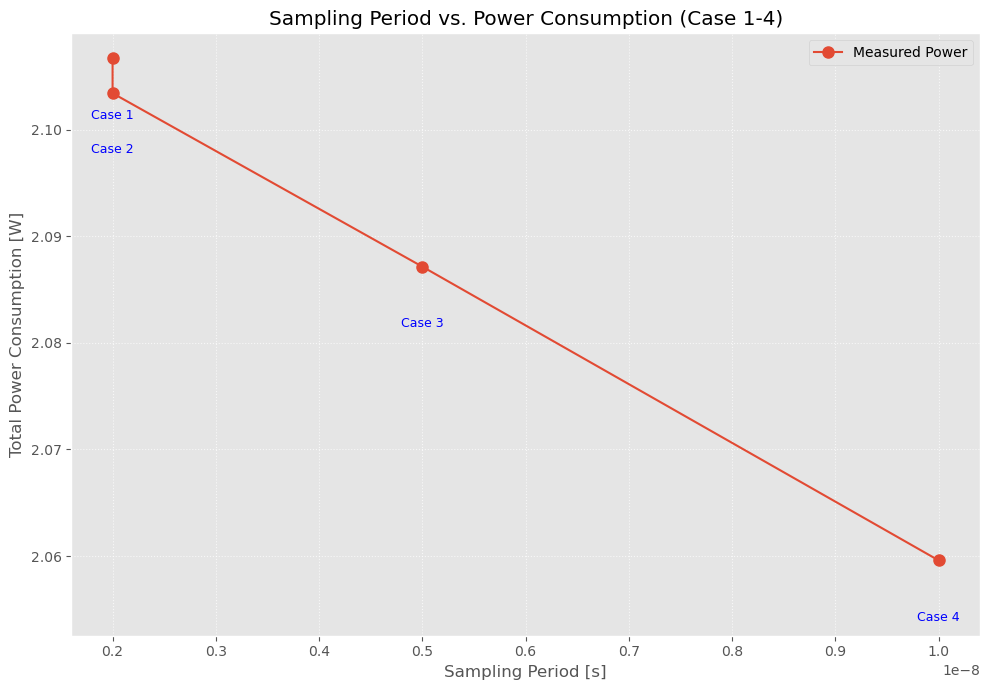

In [29]:
# --- Cell 6: 【解析】Case 1-4 サンプリング周期 vs 消費電力 (実行) ---

# 1. 解析したいケース番号のリストを定義
case_numbers_to_run = [1, 2, 3, 4] 

# 2. Cell 3 で定義した「解析ループ関数」を実行
all_results_1_4 = run_sampling_period_analysis(case_numbers_to_run)

# 3. Cell 3 で定義した「プロット関数」を実行
if all_results_1_4:
    plot_sampling_period_comparison(all_results_1_4, OUTPUT_DIR)
else:
    print("解析結果が空のため、プロットはスキップされました。")

In [30]:
import pandas as pd

# Cell 5 と Cell 6 の実行によってメモリに保存されたリストを結合します。

print("--- 全ケース (Case 1-10) の定量化サマリー ---")

try:
    # 2つの結果リストを結合
    # (Cell 5 のリスト変数: all_results, Cell 6 のリスト変数: all_results_1_4)
    combined_results_list = all_results_1_4 + all_results
    
    # 結合したリストからDataFrameを作成し、Case番号でソート
    final_df = pd.DataFrame(combined_results_list).set_index('Case').sort_index()
    
    # 表示する列を定義
    columns_to_display = [
        'Vpp (V)', 
        'Power (W)', 
        'Power_per_meter (W/m)', 
        'Sampling Period (s)', 
        'Horizontal Scale (s/div)'
    ]
    
    # 存在しない列は NaN (Not a Number) として表示される
    print(final_df[columns_to_display])

except NameError as e:
    print(f"\nエラー: 変数が見つかりません ({e})")
    print("Cell 5 (Case 5-10) と Cell 6 (Case 1-4) の両方を実行してください。")
except Exception as e:
    print(f"予期せぬエラーが発生しました: {e}")

--- 全ケース (Case 1-10) の定量化サマリー ---
      Vpp (V)  Power (W)  Power_per_meter (W/m)  Sampling Period (s)  \
Case                                                                   
1      4720.0   2.106667                    NaN         2.000000e-09   
2      4680.0   2.103407                    NaN         2.000000e-09   
3      4680.0   2.087136                    NaN         5.000000e-09   
4      4680.0   2.059585                    NaN         1.000000e-08   
5      1040.0   0.047850               0.487768         2.000000e-09   
6      2120.0   0.176735               1.801578         2.000000e-09   
7      3040.0   0.611609               6.234544         2.000000e-09   
8      4120.0   1.531028              15.606813         2.000000e-09   
9      5160.0   2.701010              27.533235         2.000000e-09   
10     6200.0   4.749452              48.414398         2.000000e-09   

      Horizontal Scale (s/div)  
Case                            
1                       0.0001  
2 

--- バッチ処理を開始します (対象: [1, 2, 3, 4]) ---

            PROCESSING CASE 1         
--- ファイル読み込み開始: testdata/ALL0001.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0001
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 4720.00 V
リサージュグラフを output/Case_1/Lissajous_Case_1.png に保存しました。
Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します...

--- [Case 1] 消費電力の計算結果 (修正版) ---
リサージュ図形の総面積 (Area_VV): 1276768.00 [V*V]
総エネルギー (E_total): 4.21e-03 [J]
総計測時間 (t_total): 0.0020 [s]
----------------------------------------
平均消費電力 (P): 2.1067 [W]

            PROCESSING CASE 2         
--- ファイル読み込み開始: testdata/ALL0002.CSV ---
メタデータの抽出成功:
  MEMORY_LENGTH: 1000000
  SAMPLING_PERIOD: 2e-09
  TRIGGER_ADDRESS: 504999
  HORIZONTAL_SCALE: 0.0002
データ読み込み完了 (サンプル数: 1000000)
DCオフセットを除去しました。
CH1 Vpp (印加電圧): 4680.00 V
リサージュグラフを output/Case_2/Lissajous_Case_2.png に保存しました。
Numba (JITコンパイル) を使用して 1000000 点のフルデータで面積計算を実行します...

--- [Case 2] 消費電力の計

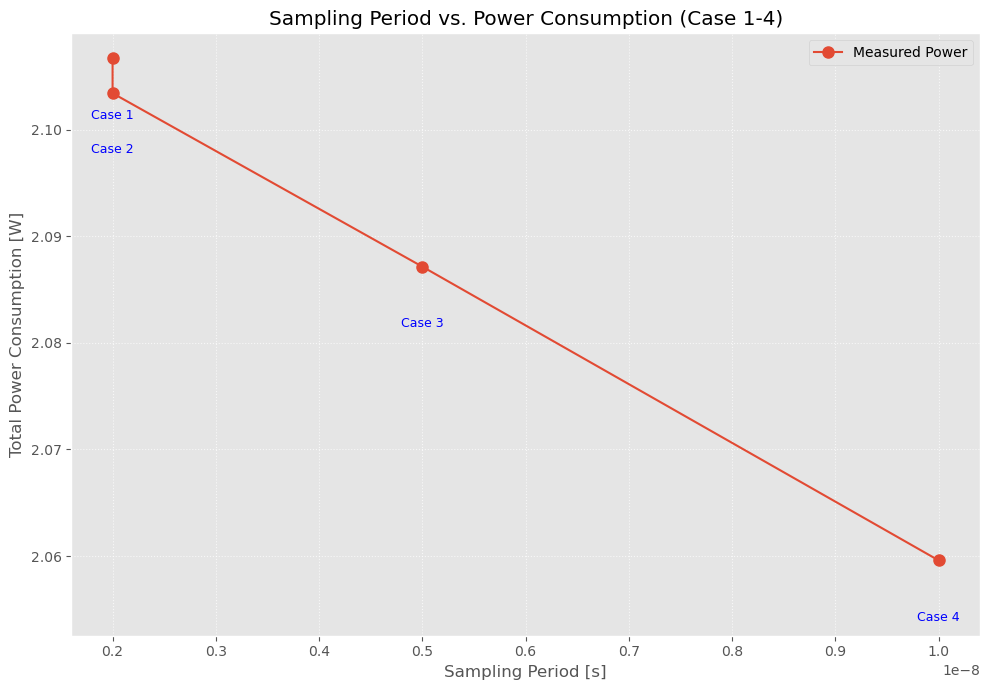

In [31]:
# --- Cell 6: 【解析】Case 1-4 サンプリング周期 vs 消費電力 (実行) ---

# 1. 解析したいケース番号のリストを定義
case_numbers_to_run = [1, 2, 3, 4] 

# 2. Cell 3 で定義した「解析ループ関数」を実行
all_results_1_4 = run_sampling_period_analysis(case_numbers_to_run)

# 3. Cell 3 で定義した「プロット関数」を実行
if all_results_1_4:
    plot_sampling_period_comparison(all_results_1_4, OUTPUT_DIR)
else:
    print("解析結果が空のため、プロットはスキップされました。")

--- 最小二乗法による電圧(Vpp) vs 電力密度(W/m) の関係式導出 ---

--- 計算結果 ---
関係式 (Y = mX + c):
  Power_per_meter [W/m] = 0.009082 * Vpp [V] + -16.1367
決定係数 (R^2): 0.8888

近似グラフを output/Comparison_Vpp_vs_Power_Fit.png に保存しました。


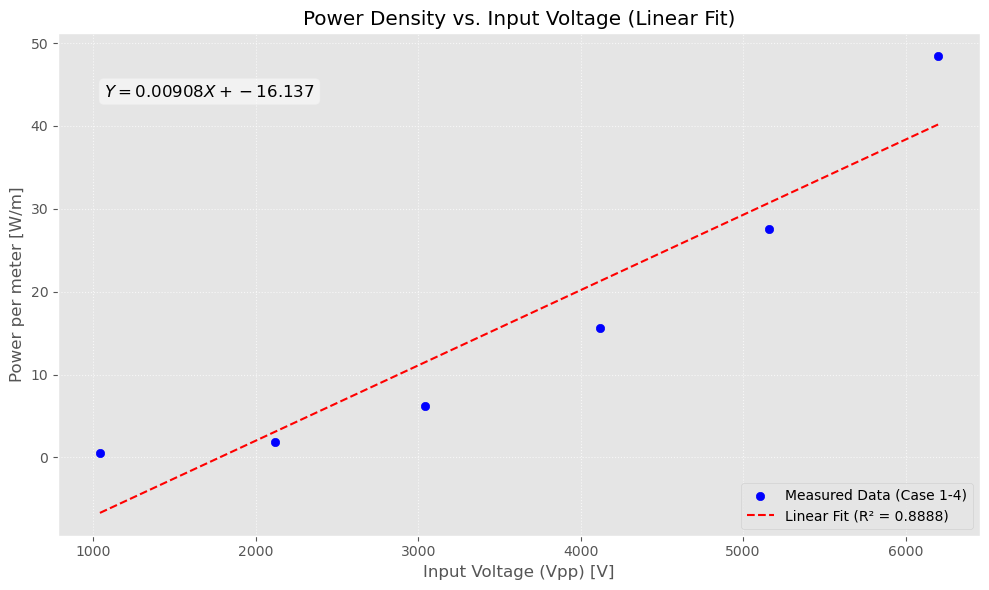

In [32]:

from sklearn.metrics import r2_score

print("--- 最小二乗法による電圧(Vpp) vs 電力密度(W/m) の関係式導出 ---")

if 'results_df' not in locals():
    print("エラー: 'results_df' が見つかりません。")
    print("先に Cell 5 (または Cell 6) を実行してデータを生成してください。")
else:
    # 1. データの準備
    # (results_df は Cell 5 または Cell 6 で作成されたもの)
    X = results_df['Vpp (V)']
    Y = results_df['Power_per_meter (W/m)']
    
    # 2. 最小二乗法 (1次関数: Y = mX + c) でフィッティング
    # np.polyfit が [m (傾き), c (切片)] を返す
    slope, intercept = np.polyfit(X, Y, 1)
    
    # 3. 近似式のY座標を計算
    Y_fit = slope * X + intercept
    
    # 4. R^2 (決定係数) を計算して、当てはまりの良さを評価
    r_squared = r2_score(Y, Y_fit)
    
    print("\n--- 計算結果 ---")
    print(f"関係式 (Y = mX + c):")
    print(f"  Power_per_meter [W/m] = {slope:.6f} * Vpp [V] + {intercept:.4f}")
    print(f"決定係数 (R^2): {r_squared:.4f}")
    
    
    # --- 5. 比較グラフの作成 ---
    fig_fit, ax_fit = plt.subplots(figsize=(10, 6))
    
    # 1. 元データの散布図をプロット
    ax_fit.scatter(X, Y, color='blue', label='Measured Data (Case 1-4)')
    
    # 2. 近似直線をプロット
    ax_fit.plot(X, Y_fit, color='red', linestyle='--', 
                label=f'Linear Fit (R² = {r_squared:.4f})')
    
    ax_fit.set_title('Power Density vs. Input Voltage (Linear Fit)')
    ax_fit.set_xlabel('Input Voltage (Vpp) [V]')
    ax_fit.set_ylabel('Power per meter [W/m]')
    ax_fit.legend()
    ax_fit.grid(True, linestyle=':', alpha=0.7)
    
    # グラフ内に式をテキストで表示
    eq_text = f'$Y = {slope:.5f} X + {intercept:.3f}$'
    ax_fit.text(0.05, 0.9, eq_text, transform=ax_fit.transAxes, 
                fontsize=12, va='top', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
    
    plt.tight_layout()
    # 比較サマリーは output 直下に保存
    comp_save_path = os.path.join(OUTPUT_DIR, "Comparison_Vpp_vs_Power_Fit.png")
    plt.savefig(comp_save_path, dpi=150)
    print(f"\n近似グラフを {comp_save_path} に保存しました。")
    plt.show()

--- 最小二乗法 (2次関数) による電圧(Vpp) vs 電力密度(W/m) の関係式導出 ---

--- 計算結果 (2次関数) ---
関係式 (Y = aX^2 + bX + c):
  a = 2.102455e-06
  b = -6.177276e-03
  c = 5.0605
決定係数 (R^2): 0.9976

近似グラフを output/Comparison_Vpp_vs_Power_Quadratic_Fit.png に保存しました。


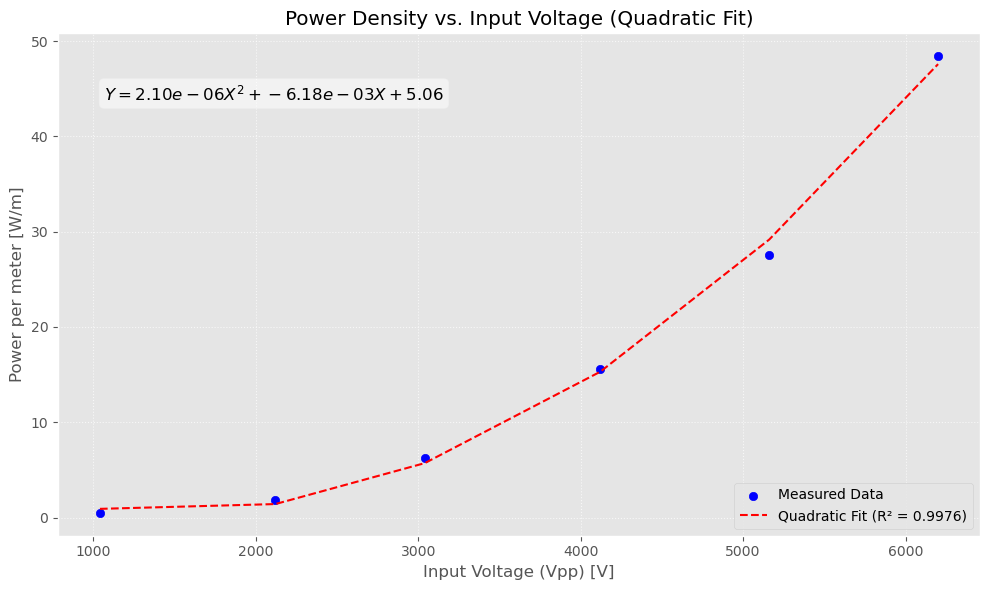

In [ ]:
# --- Cell 8: 【解析】最小二乗法（2次関数）による電圧-電力関係 ---

# (★ Cell 1 で numpy と sklearn.metrics のインポートが必要)
from sklearn.metrics import r2_score
import numpy as np

print("--- 最小二乗法 (2次関数) による電圧(Vpp) vs 電力密度(W/m) の関係式導出 ---")

if 'results_df' not in locals():
    print("エラー: 'results_df' が見つかりません。")
    print("先に Cell 5 (または Cell 6) を実行してデータを生成してください。")
else:
    # 1. データの準備
    X = results_df['Vpp (V)']
    Y = results_df['Power_per_meter (W/m)']
    
    # --- ★★★ 2次関数でフィッティング ★★★ ---
    # np.polyfit(X, Y, 2) が [a, b, c] (Y = aX^2 + bX + c) を返す
    params = np.polyfit(X, Y, 2)
    a, b, c = params
    
    # 3. 近似式の多項式関数を作成
    poly_func = np.poly1d(params)
    
    # 4. 近似式のY座標を計算
    # (プロット用に、Xをソートしてから計算すると線がきれいになる)
    X_sorted = X.sort_values()
    Y_fit_quad = poly_func(X_sorted)
    
    # 5. R^2 (決定係数) を計算
    r_squared = r2_score(Y, poly_func(X)) # poly_func(X) で元のX順のYを計算
    
    print("\n--- 計算結果 (2次関数) ---")
    print(f"関係式 (Y = aX^2 + bX + c):")
    print(f"  a = {a:.6e}")
    print(f"  b = {b:.6e}")
    print(f"  c = {c:.4f}")
    print(f"決定係数 (R^2): {r_squared:.4f}")
    
    
    # --- 6. 比較グラフの作成 ---
    fig_fit, ax_fit = plt.subplots(figsize=(10, 6))
    
    # 1. 元データの散布図をプロット
    ax_fit.scatter(X, Y, color='blue', label='Measured Data')
    
    # 2. 2次関数の近似曲線をプロット
    ax_fit.plot(X_sorted, Y_fit_quad, color='red', linestyle='--', 
                label=f'Quadratic Fit (R² = {r_squared:.4f})')
    
    ax_fit.set_title('Power Density vs. Input Voltage (Quadratic Fit)')
    ax_fit.set_xlabel('Input Voltage (Vpp) [V]')
    ax_fit.set_ylabel('Power per meter [W/m]')
    ax_fit.legend()
    ax_fit.grid(True, linestyle=':', alpha=0.7)
    
    # グラフ内に式をテキストで表示 (指数表記)
    eq_text = f'$Y = {a:.2e} X^2 + {b:.2e} X + {c:.2f}$'
    ax_fit.text(0.05, 0.9, eq_text, transform=ax_fit.transAxes, 
                fontsize=12, va='top', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
    
    plt.tight_layout()
    # 比較サマリーは output 直下に保存
    comp_save_path = os.path.join(OUTPUT_DIR, "Comparison_Vpp_vs_Power_Quadratic_Fit.png")
    plt.savefig(comp_save_path, dpi=150)
    print(f"\n近似グラフを {comp_save_path} に保存しました。")
    plt.show()